In [31]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier
from deslib.des.knop import KNOP
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [32]:
data = 'Adult_TrainDataset.csv'

df = pd.read_csv(data)

df.replace(' ?', np.nan, inplace=True)

In [33]:
income = np.asarray(df['Income'])
df.drop('Income', axis=1, inplace=True)

In [34]:
col_names = df.columns
categorical = [var for var in df.columns if df[var].dtype=='O']

In [35]:
dict_fills = {}
for each_column in col_names:
    if each_column in df.select_dtypes(['object']).columns:
        dict_fills[each_column] = df[each_column].mode()[0]
        df[each_column].fillna(dict_fills[each_column], inplace = True)
    elif each_column in df.select_dtypes(['float64']).columns:
        dict_fills[each_column] = df[each_column].median()
        df[each_column].fillna(dict_fills[each_column], inplace = True)
    else:
        dict_fills[each_column] = df[each_column].median()
        df[each_column].fillna(dict_fills[each_column], inplace = True)

In [36]:
# Removing the outliers

def removeOutliers(data, columns):
    first_time = True
    for col in columns:
        Q3 = np.quantile(data[col], 0.75)
        Q1 = np.quantile(data[col], 0.25)
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        if (lower_range != upper_range):
            outlier_list = [x for x in data[col] if ((x < lower_range) or (x > upper_range))]
            if (first_time):
                array_outlier = data.index[data[col].isin(outlier_list) == True]
                first_time = False
            else:
                array_outlier = np.hstack((array_outlier, data.index[data[col].isin(outlier_list) == True]))

    data.drop(np.unique(array_outlier), axis= 0 , inplace = True)
    data.reset_index(drop=True, inplace = True)

    return (data, array_outlier)

numeric_col = []
for each_column in df.select_dtypes(['int64']).columns:
    numeric_col.append(each_column)
for each_column in df.select_dtypes(['float64']).columns:
    numeric_col.append(each_column)


df, drop_indexes = removeOutliers (df, numeric_col)
income = np.delete(income, np.unique(drop_indexes))

In [37]:
# creating instance of one-hot-encoder
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
# passing bridge-types-cat column (label encoded values of bridge_types)
onehotencoder_data = enc.fit_transform(df[categorical]).toarray()
# make a dataframe for new column
list_columns_name = []
for i in range(len(onehotencoder_data[0])):
    list_columns_name.append('Type '+ str(i+1))
enc_df = pd.DataFrame(data=onehotencoder_data , columns= list_columns_name)

# merge with main df bridge_df on key values
df = df.join(enc_df)
for col in df.select_dtypes(['object']).columns:
    df.drop(col, axis=1, inplace=True)

In [38]:
learn_scaler=StandardScaler().fit(df)
standard_X = learn_scaler.transform(df)

In [39]:
data_test = 'Adult_TestDataset.csv'
X_test = pd.read_csv(data_test)

X_test.replace({'Income': {' <=50K.': ' <=50K', ' >50K.': ' >50K'}}, inplace=True)

y_test = np.asarray(X_test['Income'])
X_test.drop('Income', axis=1, inplace=True)
X_test.replace(' ?', np.nan, inplace=True)

In [40]:
for each_column in X_test.columns:
    if each_column in X_test.select_dtypes(['object']).columns:
        X_test[each_column].fillna(dict_fills[each_column], inplace = True)
    elif each_column in X_test.select_dtypes(['float64']).columns:
        X_test[each_column].fillna(dict_fills[each_column], inplace = True)
    else:
        X_test[each_column].fillna(dict_fills[each_column], inplace = True)


onehotencoder_data = enc.transform(X_test[X_test.select_dtypes(['object']).columns]).toarray()
list_columns_name = []
for i in range(len(onehotencoder_data[0])):
    list_columns_name.append('Type '+ str(i+1))
enc_test = pd.DataFrame(data=onehotencoder_data , columns= list_columns_name)
X_test = X_test.join(enc_test)
for col in X_test.select_dtypes(['object']).columns:
    X_test.drop(col, axis=1, inplace=True)

In [41]:
standard_X_test = learn_scaler.transform(X_test)

In [42]:
def set_hyperparameter (pool_classifiers, X_dsel, y_dsel, standard_X_test, y_test):

    k_range = np.linspace(2, 40, 39, dtype= int)

    score_of_best_setting = 0
    for kn in k_range :
            kn = int(kn)
            dynamic_selection_model = KNOP(pool_classifiers=pool_classifiers, k=kn,  random_state=None)
            dynamic_selection_model.fit(X_dsel, y_dsel)
            y_predict = dynamic_selection_model.predict(standard_X_test)
            precision, recall, fscore, support = score(y_test, y_predict)

            score_of_setting = (dynamic_selection_model.score(standard_X_test, y_test)*1) + ((fscore[0])*1) + ((fscore[1])*2)
            if (score_of_setting > score_of_best_setting):
                score_of_best_setting = score_of_setting
                best_setting = kn
    return(best_setting)

20
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.89     12435
        >50K       0.66      0.60      0.63      3846

    accuracy                           0.83     16281
   macro avg       0.77      0.75      0.76     16281
weighted avg       0.83      0.83      0.83     16281



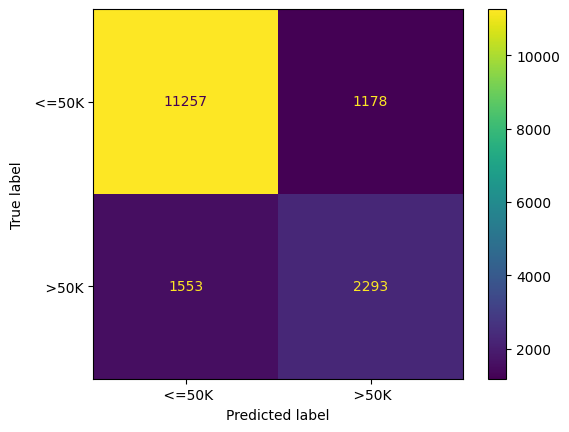

In [43]:
X_train, X_dsel, y_train, y_dsel = train_test_split(standard_X, income, test_size=0.5, random_state=0, stratify = income)

# Train a pool of 10 classifiers
pool_classifiers = BaggingClassifier( n_estimators=10)
pool_classifiers.fit(X_train, y_train)

# Set Hyperparameter
k = set_hyperparameter(pool_classifiers, X_dsel, y_dsel, standard_X_test, y_test)
print(k)

# Initialize the DES model
dynamic_selection_model = KNOP(pool_classifiers=pool_classifiers, k=k,  random_state=None)
dynamic_selection_model.fit(X_dsel, y_dsel)

y_predict = dynamic_selection_model.predict(standard_X_test)
print(classification_report(y_test, y_predict))
cm = confusion_matrix(y_test, y_predict, labels=dynamic_selection_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dynamic_selection_model.classes_)
disp.plot()
plt.show() 

In [44]:
dynamic_selection_model.score(standard_X_test, y_test)

0.8322584607825072

In [45]:
dynamic_selection_model.predict_proba(standard_X_test)

array([[1.00000000e+00, 0.00000000e+00],
       [9.99725422e-01, 2.74578156e-04],
       [9.99908584e-01, 9.14158739e-05],
       ...,
       [0.00000000e+00, 1.00000000e+00],
       [9.99993210e-01, 6.79035870e-06],
       [3.22954647e-02, 9.67704535e-01]])